In [1]:
import pandas as pd  # for requirements: install fastparquet as well
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import folium
from scipy.spatial import Voronoi
from math import floor, dist  # not needed in requirements
from tqdm import tqdm

# FUNCTIONS

In [2]:
def assign_georank(enb_df, src_id, precision=1000):
    cells = np.array(enb_df[['LAT','LON']])
    centroid = np.array(enb_df[['LAT','LON']].loc[enb_df['LocInfo']==src_id]) 
    distances = np.linalg.norm(cells-centroid, axis=1) * precision   # normalized distances to centroid, between 0 and 100
    enb_df['Georank'] = [floor(d) for d in distances] 
    return enb_df

In [5]:
def compute_distance(data):
    dist_ser = pd.Series()
    for idx,row in data.iterrows():
        dist_ser[idx] = max(0.1, dist((row.srcLAT,row.srcLON), (row.dstLAT,row.dstLON))*10000)
    data['Distance'] = dist_ser
    return data

def join_ranks(data, enb_df):
    data = data.join(enb_df[['LocInfo','Georank']].set_index('LocInfo'), on='srcLocInfo')
    data.rename(columns={'Georank':'srcRank'}, inplace=True)
    data = data.join(enb_df[['LocInfo','Georank']].set_index('LocInfo'), on='dstLocInfo')
    data.rename(columns={'Georank':'dstRank'}, inplace=True)
    return data


def compute_weight(data, method='inverse', absolute=False, enb_df=None):
    if method == 'inverse':
        data['Weight'] = 1/(data['nbHO15'])  
        
    elif method == 'prop':
        ho_max, ho_min = data['nbHO15'].max(), data['nbHO15'].min()
        data['Weight'] = (ho_max - data.nbHO15)/(ho_max-ho_min)
        
    elif method == 'distance':
        if 'Distance' not in data.columns:
            data = compute_distance(data)
        data['Weight'] = data.Distance / data.nbHO15
        
    elif method == 'rank':
        if 'srcRank' not in data.columns:
            data = join_ranks(data, enb_df)
        ser = pd.Series()
        if absolute:
            for idx,row in data.iterrows():
                ser[idx] = max(1, abs(row.srcRank - row.dstRank)) / row.nbHO15
        else:
            for idx,row in data.iterrows():   
                ser[idx] = max(1, row.srcRank - row.dstRank +1) / row.nbHO15
        data['Weight'] = ser
        
    elif method == 'rank-dist':
        if 'srcRank' not in data.columns:
            data = join_ranks(data, enb_df)
        if 'Distance' not in data.columns:
            data = compute_distance(data)
        ser = pd.Series()
        if absolute:
            for idx,row in data.iterrows():
                ser[idx] = max(1, abs(row.srcRank - row.dstRank)) / row.nbHO15
        else:
            for idx,row in data.iterrows():
                ser[idx] = max(1, row.srcRank - row.dstRank +1) / row.nbHO15
        data['Weight'] = ser * data.Distance
        
    elif method == 'log':
        ho_max = data['nbHO15'].max()
        data['Weight'] = np.log(ho_max) - np.log(data.nbHO15)
        
    else:
        raise ValueError('Invalid method. Choose between inverse, prop, distance, rank, rank-dist, or log.')
    return data

In [6]:
def compute_path_ho(data, path):
    path_ho = 0
    for i in range(len(path)-1):
        arc_ho = data.loc[(data['srcLocInfo']==path[i]) & (data['dstLocInfo']==path[i+1])]['nbHO15'].iloc[0]
        arc_weight = data.loc[(data['srcLocInfo']==path[i]) & (data['dstLocInfo']==path[i+1])]['Weight'].iloc[0]
        #print('Number of handovers between', path[i], 'and', path[i+1],': ', arc_ho, '\tWeight: ', arc_weight)
        path_ho += arc_ho
    return int(path_ho)

def update_graph(graph, path, method='half'):
    if method == 'half':
        for i in range(len(path)-1):
            src, dst = path[i], path[i+1]
            weight = graph[src][dst]['Weight']
            graph[src][dst]['Weight'] = weight*2
            #print('Previous weight:', weight, '\tNew weight:', graph[src][dst]['Weight']) 
    else:
        raise ValueError('Invalid method. Choose between half or min.')
    return graph

In [7]:
def create_map():
    map = folium.Map([45.73303, 4.82297], tiles="OpenStreetMap", zoom_start=13)
    print('Creating base station map...')
    return map

def add_stations(map, df, name='4G stations'):
    print('Adding '+name+' layer')
    fg = folium.FeatureGroup(name=name) # Name as it will appear in Layer control
    enb_ids = df.srcLocInfo.unique()
    for id in enb_ids:
        enb_data = df.loc[df['srcLocInfo']==id]
        fg.add_child(folium.Marker(
            location=[enb_data['srcLAT'].iloc[-1], enb_data['srcLON'].iloc[-1]],
            popup=enb_data['srcLocInfo'].iloc[-1],
        ))
    map.add_child(fg)
    
def add_stations_by_centrality(map, df, name='4G stations'):
    print('Adding '+name+' layer...')
    fg = folium.FeatureGroup(name=name) # Name as it will appear in Layer control
    enb_color = {0:'blue', 0.007:'green', 0.026:'yellow', 0.05:'orange', 0.5:'red'}
    for idx,row in df.iterrows():
        ec = [v for k,v in enb_color.items() if row['BC'] <= k]
        fg.add_child(folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            popup=row['LocInfo'],
            tooltip='Centrality: '+str(row['BC']),
            color='black',
            weight=1,
            fill=True,
            fill_color=ec[0],
            fill_opacity=0.9,
            radius=10
        ))
    map.add_child(fg)
    
def close_map(map, filename):
    folium.LayerControl().add_to(map)
    map.save('maps\\'+filename)
    print('Closing', filename, 'map.')
    
def add_voronoi(map, points):
    print('Adding Voronoi layer')
    vor = Voronoi(list(zip(points['LAT'].tolist(), points['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name='Voronoi cells', show=True)
    for enb, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        if -1 not in region and region != []:
            region_coords = []
            for vertex in region:
                region_coords.append(vor.vertices[vertex])
            fg.add_child(folium.Polygon(
                region_coords,
                color="black",
                weight=1,
                fill_color="darkgray",
                fill_opacity=0.2,
                fill=True,
            ))
    map.add_child(fg)
    
    
def add_flows(map, data, name='4G Handovers', min_weight=900):
    print('Adding Flow layer', name)
    fg = folium.FeatureGroup(name=name)
    flow_weight = {100000:2, 200000:4, 300000:6, 400000:8, 500000:10}
    flow_color = {2:'blue', 4:'green', 6:'yellow', 8:'orange', 10:'red'}
    for idx, row in data.iterrows():
        if row['nbHO15'] >= min_weight:
            fw = [v for k,v in flow_weight.items() if row['nbHO15'] <= k]
            fg.add_child(folium.PolyLine(
                [(row['srcLAT'], row['srcLON']), (row['dstLAT'], row['dstLON'])],
                color = flow_color[fw[0]],
                weight = fw[0],
                opacity = 0.8,
                tooltip = 'Weight: '+str(row['nbHO15'])
            ))
    map.add_child(fg)
    
    
def add_path(map, enb_data, path_list, name='Path', color='#AA0000', show_path=True, voronoi=True):
    print('Adding Path layer', name)
    fg = folium.FeatureGroup(name=name)
    if show_path:
        fg.add_child(folium.PolyLine(
            locations=zip(path_list['LAT'].tolist(), path_list['LON'].tolist()),
            color = color,
            opacity = 0.8,
            weight = 5
        ))

    if voronoi:
        vor = Voronoi(list(zip(enb_data['LAT'].tolist(), enb_data['LON'].tolist())))  # Careful with the inversion!!  
        for enb_idx, reg_idx in enumerate(vor.point_region):
            region = vor.regions[reg_idx]
            cell_locinfo = enb_data.LocInfo.iloc[enb_idx]
            if -1 not in region and region != []:
                region_coords = []
                if cell_locinfo in path_list.LocInfo.tolist():
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
    map.add_child(fg)
    

def add_gt_path(map, data, name='Path', color='#AA0000'):
    print('Adding Path layer', name)
    fg = folium.FeatureGroup(name=name)
    fg.add_child(folium.PolyLine(
        locations=zip(data['LAT'].tolist(), data['LON'].tolist()),
        color = color,
        opacity = 0.8,
        weight = 5
    ))
    map.add_child(fg)


def add_voronoi_path(map, enb_data, cells_data, name='Cells path', color='green'):
    vor = Voronoi(list(zip(enb_data['LAT'].tolist(), enb_data['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name=name, show=True)
    for enb_idx, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        cell_locinfo = enb_data.LocInfo.iloc[enb_idx]
        if -1 not in region and region != []:
            region_coords = []
            if type(cells_data) == list:
                if cell_locinfo in cells_data:
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
            else:
                if cell_locinfo in cells_data['LocInfo'].values:
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
    map.add_child(fg)

In [8]:
def find_closest_enb(path, enb_df, remove_duplicates=True):
    enb_path = []
    enb_list, enb_coords = enb_df.LocInfo.tolist(), list(zip(enb_df.LON.tolist(), enb_df.LAT.tolist()))
    enb_dict = dict(zip(enb_list, enb_coords))
    for idx,row in path.iterrows():
        point = [row.LON, row.LAT]
        distances = {enb: dist(point, enb_dict[enb]) for enb in enb_list}
        closest_enb = min(distances, key=distances.get)
        enb_path.append(closest_enb)
    if remove_duplicates:
        return list(dict.fromkeys(enb_path)) # remove duplicates while preserving order
    return enb_path


def path_score(path_ref, path_ho, enb_df):
    POS = path_ref # All positive elements
    NEG = enb_df.loc[~enb_df.LocInfo.isin(path_ref)].LocInfo.tolist() # All negative elements
    TP = len(set(path_ho).intersection(POS))     # True positives
    FP = len(set(path_ho).intersection(NEG))     # False positives
    FN = len(set(POS).difference(path_ho))       # False negatives
    precision = TP / (TP + FP)          # How many retrieved elements are relevant?
    recall = TP / (TP + FN)             # How many relevant elements are retrieved?
    f1_score = 2*TP / (2*TP + FP + FN)  # Harmonic mean of precision and recall
    return {'Precision': precision, 'Recall': recall, 'F1_Score': f1_score}

In [9]:
def smooth_path(path, enb_data, interp_coef=3):
    path_df = pd.DataFrame(index=np.arange(0, interp_coef*(len(path)-1), 1), columns=['LocInfo','LAT','LON'])
    path_df = path_df.astype({'LAT':np.float64, 'LON':np.float64})
    for i in range(0, len(path)):
        row = enb_data.loc[enb_data['LocInfo']==path[i]]
        path_df.loc[i*interp_coef, 'LocInfo'] = row['LocInfo'].iloc[0]
        path_df.loc[i*interp_coef, 'LAT'] = row['LAT'].iloc[0]
        path_df.loc[i*interp_coef, 'LON'] = row['LON'].iloc[0]
    # Interpolate coordinates
    path_df['LAT'] = path_df['LAT'].interpolate()
    path_df['LON'] = path_df['LON'].interpolate()
    # Interpolate LocInfos
    enb_list = find_closest_enb(path_df[['LAT','LON']], enb_data, remove_duplicates=False)
    path_df['LocInfo'] = pd.Series(enb_list)
    #path_smooth = path_df.LocInfo.tolist()
    return path_df.drop_duplicates(subset=['LocInfo']) # remove duplicates while preserving order

# GLOBAL VARIABLES

In [10]:
SRC_LIST = ['8102f8100000ba6b',
            '8102f8100000ba51',
            '8102f8100000ba43',
            '8102f810000099ca',
            '8102f810000099a4',
            '8102f81000009f1f',
            '8102f8100000ba50',
            '8102f8100000997a',
            '8102f8100000babe',
            '8102f810000099c6',
            '8102f81000009fd7',
            '8102f81000009977',
            '8102f810000099ae',
            '8102f810000099cd',
            '8102f810000099cf',
            '8102f81000009b8e',
            '8102f8100000ba3e']

DST_LIST = ['8102f8100000ba36',
            '8102f8100000ba3b',
            '8102f8100000ba42',
            '8102f810000099c9',
            '8102f810000099a9',
            '8102f81000009987',
            '8102f81000009985',
            '8102f8100000997b',
            '8102f8100000ba6e',
            '8102f8100000ba66',
            '8102f8100000ba6d',
            '8102f8100000ba5d',
            '8102f81000009998',
            '8102f8100000ba62',
            '8102f81000009bad',
            '8102f81000009b5e',
            '8102f8100000ba68']

In [11]:
METHOD = 'rank'
ABS = False
NB_PATHS = 1
INTERP_COEF = 10

# CITY-WIDE ANALYSIS
## 1. Import data 

In [12]:
agg_df_day = pd.read_parquet('..\\Processed_data\\HO_AGG_16-22_DAYTIME_4G_coords_reduced.snappy.parquet', engine='fastparquet')
ho_df_day = agg_df_day.loc[agg_df_day.srcLocInfo != agg_df_day.dstLocInfo]
ho_df_day

,srcLocInfo,dstLocInfo,nbHO15,srcTechno,srcLON,srcLAT,dstTechno,dstLON,dstLAT
index,,,,,,,,,
3190,8102f8100000994e,8102f81000009952,174,4G,4.818062,45.762236,4G,4.827545,45.752980
3191,8102f8100000994e,8102f81000009957,3879,4G,4.818062,45.762236,4G,4.826112,45.774444
3192,8102f8100000994e,8102f81000009958,1163,4G,4.818062,45.762236,4G,4.835282,45.761386
3193,8102f8100000994e,8102f8100000995b,17,4G,4.818062,45.762236,4G,4.858331,45.753607
3195,8102f8100000994e,8102f81000009963,553,4G,4.818062,45.762236,4G,4.830520,45.753373
...,...,...,...,...,...,...,...,...,...
20101,8102f8100000bad0,8102f81000009b28,64321,4G,4.820179,45.775520,4G,4.819723,45.771390
20102,8102f8100000bad0,8102f8100000a01d,5526,4G,4.820179,45.775520,4G,4.789162,45.763888
20103,8102f8100000bad0,8102f8100000a104,15,4G,4.820179,45.775520,4G,4.863723,45.755097


In [13]:
PATH_TOPO = '..\\..\\Data_Handover\\TOPO\\Lyon\\part-00000-2f038a97-7faf-46f3-aee2-b73b52bf2cba.snappy.parquet'

enb_df_day = pd.read_parquet(PATH_TOPO, engine='fastparquet')
enb_df_day = enb_df_day.loc[enb_df_day['LocInfo'].isin(ho_df_day['srcLocInfo'])].reset_index(drop=True)
enb_df_day['Score'] = 0 # Nb passages through cell
enb_df_day

,LocInfo,TECHNO,LON,LAT,Score
0,8102f8100000999d,4G,4.888138,45.738378,0
1,8102f81000009b28,4G,4.819723,45.771390,0
2,8102f8100000997e,4G,4.875561,45.753615,0
3,8102f81000009976,4G,4.846672,45.729169,0
4,8102f81000009959,4G,4.822966,45.733027,0
...,...,...,...,...,...
192,8102f81000009f4a,4G,4.874679,45.764310,0
193,8102f8100000997b,4G,4.880686,45.725675,0
194,8102f8100000ba70,4G,4.867783,45.701943,0
195,8102f8100000996d,4G,4.864943,45.729614,0


In [14]:
TOTAL_HO_DAY = int(ho_df_day['nbHO15'].sum())
TOTAL_HO_DAY

78189320

## 2. Loop between all sources and destinations

In [ ]:
enb_list = enb_df_day.LocInfo.tolist()

#Problem with this method: no interpolation, so big jumps over some cells!
with tqdm(total=len(enb_list), desc='EnB BC computation') as pbar:
    for enb in enb_list:
        enb_df_day = assign_georank(enb_df_day, src_id=enb)
        ho_df_day = compute_weight(ho_df_day, METHOD, absolute=ABS, enb_df=enb_df_day) 
        G = nx.from_pandas_edgelist(ho_df_day, source='srcLocInfo', target='dstLocInfo', edge_attr='Weight', create_using=nx.DiGraph)
        bc = nx.betweenness_centrality(G, normalized=True, weight='Weight', endpoints=False, seed=None)
        # Increment cell score
        for k,v in bc.items():
            enb_df_day.loc[enb_df_day.LocInfo == k, 'Score'] += v 
        pbar.update(1)

EnB BC computation: 100%|██████████| 197/197 [05:59<00:00,  1.82s/it]


In [20]:
enb_df_day

,LocInfo,TECHNO,LON,LAT,Score,Georank
0,8102f8100000999d,4G,4.888138,45.738378,NaN,62
1,8102f81000009b28,4G,4.819723,45.771390,NaN,20
2,8102f8100000997e,4G,4.875561,45.753615,0.082470,48
3,8102f81000009976,4G,4.846672,45.729169,2.200916,30
4,8102f81000009959,4G,4.822966,45.733027,49.394322,20
...,...,...,...,...,...,...
192,8102f81000009f4a,4G,4.874679,45.764310,16.390895,48
193,8102f8100000997b,4G,4.880686,45.725675,10.128336,59
194,8102f8100000ba70,4G,4.867783,45.701943,0.000000,64
195,8102f8100000996d,4G,4.864943,45.729614,2.566876,44


In [39]:
for i in range(len(SRC_LIST)):
    ENB_SRC, ENB_DST = SRC_LIST[i], DST_LIST[i]
    print('Computing path between', ENB_SRC, 'and', ENB_DST, '['+str(i)+'/'+str(len(SRC_LIST))+']')
    enb_df_day = assign_georank(enb_df_day, src_id=ENB_SRC)
    ho_df_day = compute_weight(ho_df_day, METHOD, absolute=ABS, enb_df=enb_df_day)
    # NetworkX graph
    G = nx.from_pandas_edgelist(ho_df_day, source='srcLocInfo', target='dstLocInfo', edge_attr='Weight', create_using=nx.DiGraph)
    sp = nx.shortest_path(G, ENB_SRC, ENB_DST, weight='Weight', method='bellman-ford') # Bellman-Ford is better for directed graphs
    path = smooth_path(sp, enb_df_day, INTERP_COEF)
    print('Path length:', len(sp), '\tInterpolated path length:', len(path))
    # Increment cell score
    enb_df_day.loc[enb_df_day.LocInfo.isin(path.LocInfo.tolist()), 'Score'] += 1

Computing path between 8102f8100000ba6b and 8102f8100000ba36 [0/17]
Path length: 13 	Interpolated path length: 27
Computing path between 8102f8100000ba51 and 8102f8100000ba3b [1/17]
Path length: 11 	Interpolated path length: 26
Computing path between 8102f8100000ba43 and 8102f8100000ba42 [2/17]
Path length: 12 	Interpolated path length: 27
Computing path between 8102f810000099ca and 8102f810000099c9 [3/17]
Path length: 9 	Interpolated path length: 22
Computing path between 8102f810000099a4 and 8102f810000099a9 [4/17]
Path length: 9 	Interpolated path length: 23
Computing path between 8102f81000009f1f and 8102f81000009987 [5/17]
Path length: 8 	Interpolated path length: 20
Computing path between 8102f8100000ba50 and 8102f81000009985 [6/17]
Path length: 8 	Interpolated path length: 22
Computing path between 8102f8100000997a and 8102f8100000997b [7/17]
Path length: 8 	Interpolated path length: 22
Computing path between 8102f8100000babe and 8102f8100000ba6e [8/17]
Path length: 17 	Interpol

(array([130.,  18.,  11.,   7.,   3.,   7.,  13.,   2.,   1.,   3.]),
 array([ 0.        ,  4.93943223,  9.87886447, 14.8182967 , 19.75772894,
        24.69716117, 29.63659341, 34.57602564, 39.51545788, 44.45489011,
        49.39432234]),
 <BarContainer object of 10 artists>)

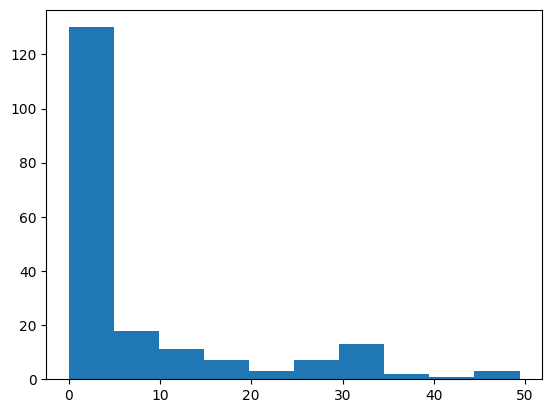

In [ ]:
plt.hist(enb_df_day.Score.tolist())

## 3. Folium visualization

In [22]:
import branca
import branca.colormap as cm

In [26]:
def add_voronoi(map, points, colormap):
    print('Adding Voronoi layer')
    vor = Voronoi(list(zip(points['LAT'].tolist(), points['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name='Voronoi cells', show=True)
    for enb, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        cell_locinfo = points.LocInfo.iloc[enb]
        if -1 not in region and region != []:
            region_coords = []
            for vertex in region:
                region_coords.append(vor.vertices[vertex])
            score = points.loc[points.LocInfo==cell_locinfo, 'Score'].iloc[0]
            fg.add_child(folium.Polygon(
                region_coords,
                color="darkgray",
                weight=1,
                fill_color=colormap(score),
                fill_opacity=0.3,
                fill=True,
                tooltip=score
            ))
    map.add_child(fg)
    map.add_child(colormap)

In [27]:
lyon = create_map()
folium.TileLayer('CartoDB Positron').add_to(lyon)
enb_df_day = enb_df_day.fillna(0)
smin, smax = enb_df_day.Score.min(), enb_df_day.Score.max()
colormap = cm.LinearColormap(colors=['lightblue','red'], index=[smin,smax],vmin=smin,vmax=smax)
add_voronoi(lyon, enb_df_day, colormap)

#close_map(lyon, 'lyon_full_daytime_'+METHOD+'_'+str(ABS)+'.html')
lyon

Creating base station map...
Adding Voronoi layer
